# Baseline Flat Classification

This notebook trains a **flat (non-hierarchical) classifier** on the merged 3D MedMNIST datasets for comparison with the hierarchical approach.

The flat classifier predicts the fine-grained label directly without the intermediate region classification step.

In [10]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from medmnist import INFO

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.cnn_3d_models import get_3d_model
from utils.trainer import Trainer
from utils.metrics import compute_metrics

set_seed(42)
print(f"Device: {DEVICE}")

Device: cuda


## 1. Load Merged Dataset

In [11]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers'],
    return_global_labels=True 
)

print("="*60)
print("MERGED DATASET INFO")
print("="*60)
# 1. Basic info table
basic_info = pd.DataFrame([{
    'Total Fine Classes': dataset_info['num_fine_classes'],
    'Train Samples': dataset_info['train_samples'],
    'Val Samples': dataset_info['val_samples'],
    'Test Samples': dataset_info['test_samples']
}])
print("\nDataset Overview:")
display(
    basic_info.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
)
# 2. Global Fine Label Mapping for Flat Classifier
print("\nGlobal Fine Label Mapping (for Flat Classifier):")
rows = []
global_map = dataset_info['global_idx_to_name']

for global_idx in sorted(global_map.keys()):
    info = global_map[global_idx]
    rows.append({
        'Global Index': int(global_idx),
        'Region': info['region'].upper(),
        'Dataset': info['dataset'].upper(),
        'Label Name': info['name']
    })
df_labels = pd.DataFrame(rows)
# Display with specific alignment
display(
    df_labels.style
    .hide(axis="index")
    .set_properties(subset=['Global Index', 'Region', 'Dataset'], **{'text-align': 'center'})
    .set_properties(subset=['Label Name'], **{'text-align': 'left'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'th.col3', 'props': [('text-align', 'left')]} # Left align 'Label Name' header
    ])
)


Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\nodulemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\adrenalmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\nodulemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\adrenalmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmn

Total Fine Classes,Train Samples,Val Samples,Test Samples
20,5679,718,1840



Global Fine Label Mapping (for Flat Classifier):


Global Index,Region,Dataset,Label Name
0,ABDOMEN,ADRENAL,normal
1,ABDOMEN,ADRENAL,hyperplasia
2,ABDOMEN,ORGAN,liver
3,ABDOMEN,ORGAN,kidney-right
4,ABDOMEN,ORGAN,kidney-left
5,ABDOMEN,ORGAN,femur-right
6,ABDOMEN,ORGAN,femur-left
7,ABDOMEN,ORGAN,bladder
8,ABDOMEN,ORGAN,spleen
9,ABDOMEN,ORGAN,pancreas


## 2. Create Wrapper DataLoaders for Flat Training

The hierarchical dataset returns `(img, coarse_label, fine_label)`. For flat training, we only need `(img, fine_label)`.

In [12]:
class FlatDataLoaderWrapper:
    """Wrapper that extracts only (img, global_fine_label) from hierarchical dataloader."""
    def __init__(self, hierarchical_loader):
        self.loader = hierarchical_loader
    
    def __iter__(self):
        # Unpack 4 values: img, coarse, fine_local, fine_global
        for imgs, coarse_labels, fine_labels, global_fine_labels in self.loader:
            # Yield image and GLOBAL label (0-19)
            yield imgs, global_fine_labels
    
    def __len__(self):
        return len(self.loader)

# Create flat loaders
flat_train_loader = FlatDataLoaderWrapper(train_loader)
flat_val_loader = FlatDataLoaderWrapper(val_loader)
flat_test_loader = FlatDataLoaderWrapper(test_loader)

print("\nFlat data loaders created")


Flat data loaders created


## 3. Build Flat Classifier

In [13]:
# Create flat classifier
num_classes = dataset_info['num_fine_classes']
architecture = MODEL_CONFIG['architecture']

# Instantiate model
model = get_3d_model(
    model_name=architecture,
    num_classes=num_classes
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nFlat classifier created:")

# Create summary table
model_summary = pd.DataFrame([{
    'Architecture': architecture,
    'Input Channels': 1,  # Assuming grayscale medical images
    'Output Classes': num_classes,
    'Total Parameters': f"{total_params:,}",
    'Trainable Parameters': f"{trainable_params:,}",
    'Device': str(DEVICE)
}])
# Display styled table
display(
    model_summary.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]}
    ])
)


Flat classifier created:


Architecture,Input Channels,Output Classes,Total Parameters,Trainable Parameters,Device
enhanced,1,20,"2,097,460","2,097,460",cuda


## 4. Train Flat Classifier

In [14]:
# Create trainer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

trainer = Trainer(
    model=model,
    train_loader=flat_train_loader,
    val_loader=flat_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler
)

# Total epochs = coarse + fine epochs for fair comparison
total_epochs = TRAINING_CONFIG['coarse_epochs'] + TRAINING_CONFIG['fine_epochs']
print(f"Training for {total_epochs} epochs...")

Training for 4 epochs...


In [15]:
# Train
history = trainer.train(num_epochs=total_epochs)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


Epoch 1/4


Validation: 100%|██████████| 90/90 [00:08<00:00, 10.24it/s]


Train Loss: 1.5810, Train Acc: 0.3958
Val Loss: 1.9084, Val Acc: 0.4276
New best validation accuracy: 0.4276

Epoch 2/4


Validation: 100%|██████████| 90/90 [00:08<00:00, 10.17it/s]


Train Loss: 1.3671, Train Acc: 0.4615
Val Loss: 1.1821, Val Acc: 0.5084
New best validation accuracy: 0.5084

Epoch 3/4


Validation: 100%|██████████| 90/90 [00:08<00:00, 11.10it/s]


Train Loss: 1.2573, Train Acc: 0.5031
Val Loss: 1.1350, Val Acc: 0.5376
New best validation accuracy: 0.5376

Epoch 4/4


Validation: 100%|██████████| 90/90 [00:08<00:00, 10.88it/s]

Train Loss: 1.1667, Train Acc: 0.5487
Val Loss: 10.4734, Val Acc: 0.2173

TRAINING COMPLETE!


## 5. Training Visualization

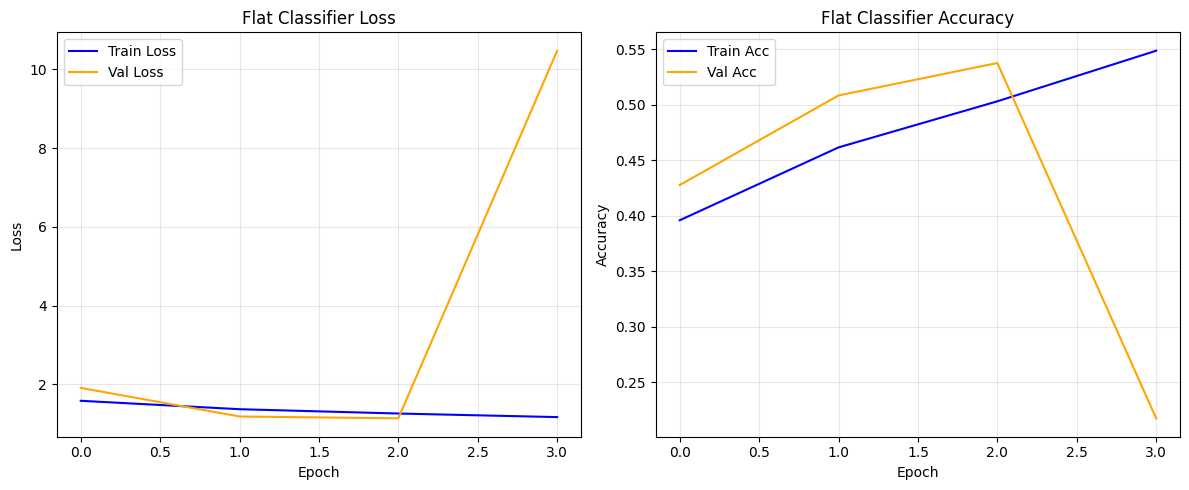

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Flat Classifier Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Flat Classifier Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PATHS['figures']}/baseline_training_{architecture}.png", dpi=150)
plt.show()

## 6. Evaluation on Test Set

In [17]:
def evaluate_flat_model(model, test_loader, device, dataset_info):
    """Evaluate a flat (non-hierarchical) model on the test set and compute metrics."""
    from utils.metrics import compute_metrics
    from medmnist import INFO

    model.eval()
    all_preds = []
    all_labels = []

    # Run inference on the test set
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device, dtype=torch.float32)

            # Normalize if images are in [0, 255]
            if imgs.max() > 1:
                imgs = imgs / 255.0
            # Convert labels to shape [B] and move to device
            labels = labels.squeeze(-1).long().to(device)
            # Forward pass and prediction
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            # Accumulate predictions and ground truth
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Placeholder label map (index → class name), can be filled using INFO if needed
    label_map = {idx: "" for idx in range(dataset_info['num_fine_classes'])}
    
    # Compute evaluation metrics using accumulated predictions
    metrics = compute_metrics(all_labels, all_preds)

    return metrics


Evaluating: 100%|██████████| 230/230 [00:08<00:00, 25.87it/s] 



TEST SET RESULTS
Accuracy: 0.1652
Macro F1: 0.0878
Weighted Recall: 0.1652

Classification Report (Per-Class Performance):
Report not generated in utils


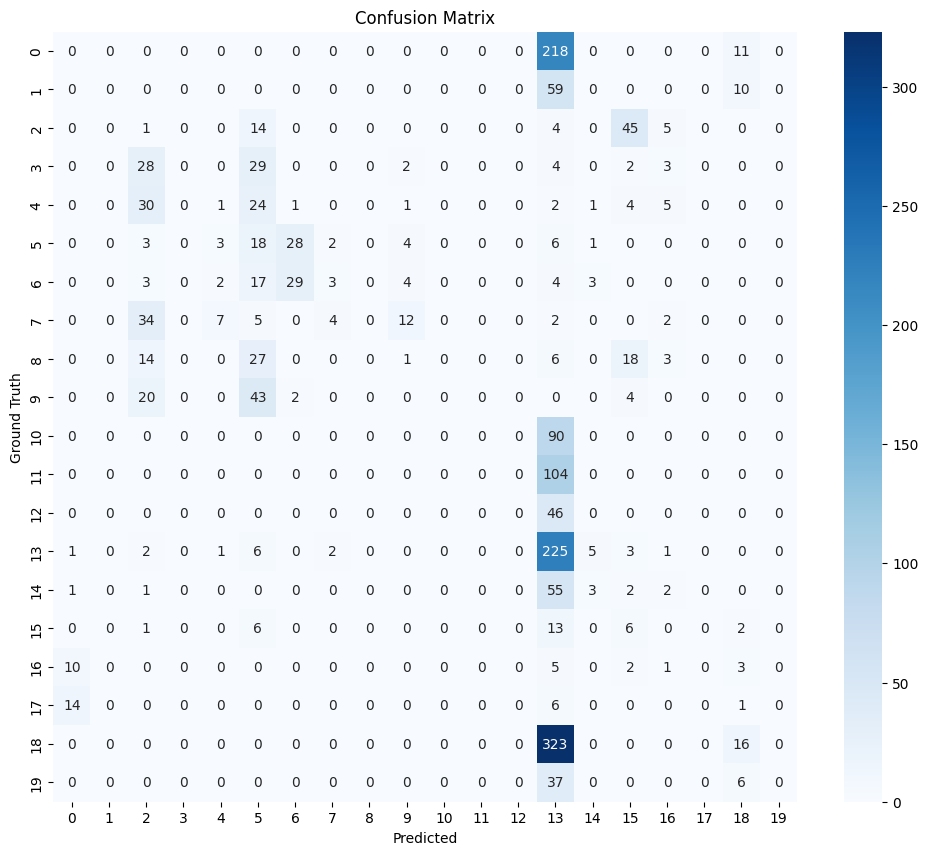

In [18]:
# Evaluate
results = evaluate_flat_model(model, flat_test_loader, DEVICE, dataset_info)
print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Macro F1: {results['f1_score']:.4f}")
print(f"Weighted Recall: {results['recall']:.4f}")
print("\nClassification Report (Per-Class Performance):")

# Re-generate report with named classes if possible, currently using IDs
print(results.get('classification_report', "Report not generated in utils"))

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.show()

## 7. Save Model

In [19]:
import os
os.makedirs(PATHS['models'], exist_ok=True)

model_path = f"{PATHS['models']}/baseline_{architecture}.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'dataset_info': dataset_info,
    'history': history,
    'test_results': results,
    'config': {
        'architecture': architecture,
        'num_classes': num_classes,
    }
}, model_path)

print(f"\n✓ Model saved to: {model_path}")


✓ Model saved to: c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\models/baseline_enhanced.pth


## 8. Summary

In [20]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nDatasets used: {', '.join(dataset_info['datasets_included'])}")
print(f"Total training samples: {dataset_info['train_samples']:,}")
print(f"\nModel architecture: {architecture}")
print(f"Number of classes: {num_classes}")
print(f"Total parameters: {total_params:,}")
print(f"\nFinal Test Accuracy: {results['accuracy']:.4f}")
print(f"\nModel saved to: {model_path}")


TRAINING SUMMARY

Datasets used: organ, nodule, adrenal, fracture, vessel
Total training samples: 5,679

Model architecture: enhanced
Number of classes: 20
Total parameters: 2,097,460

Final Test Accuracy: 0.1652

Model saved to: c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\models/baseline_enhanced.pth
